In [1]:
import numpy as np
from tqdm import tqdm
import math
import random
import matplotlib.pyplot as plt
import statistics


In [2]:
#parameters
max_range = 75
min_range = 50
rows = columns = 50
num_of_simulations = 5
iterations = 10000
dim = min(rows, columns)
b_noise_mean = 0
b_noise_sd = 1
x_noise_mean = 0
x_noise_sd = 1

In [3]:
#creating the matrix based on the parameters we get
def creating_matrix(max_range, min_range, rows, columns, x_noise_mean, x_noise_sd, b_noise_mean, b_noise_sd):
    B = np.random.rand(rows, columns)
    u, s, vh = np.linalg.svd(B, full_matrices=True)
    s_new = np.zeros(s.shape)
    s_new[0] = max_range
    rank = min(rows, columns)
    s_new[rank-1] = min_range
    
    for i in range(min(rows, columns)):
        if i == 0 or i == rank-1:
            continue
        s_new[i] = (random.uniform(0, 1)) * (max_range-min_range) + min_range

    s_new.sort()
    s_temp = np.copy(s_new)
    for i in range(min(rows, columns)):
        s_new[i] = s_temp[rank - 1 - i]

    A = np.dot(u[:, :rank] * s_new, vh)
    x = np.zeros(columns)
    for i in range(columns):
        x[i] = np.random.normal(x_noise_mean, x_noise_sd)
    M = np.dot(A, x)
    b = M + np.random.normal(b_noise_mean, b_noise_sd)
    alpha = s_new[rank-1] * s_new[rank-1]
    beta = s_new[0] * s_new[0]
    b_norm = np.linalg.norm(b)
    penrose_inverse = np.linalg.pinv(A)
    R = np.linalg.norm(penrose_inverse) * np.linalg.norm(b)
    L = beta * R + s_new[0] * b_norm
    return b, A, alpha, beta, R, L


#calculating the function value
def loss(A, x, b):
    return 0.5*np.linalg.norm(np.dot(A, x)-b)**2


#calculating the gradient value
def gradient(A, x, b):
    return np.dot(np.transpose(A), (np.dot(A, x)-b))


#ploting the results
def plot(SGD, SGD5, SGD20, SGD40, SVRG, SVRG_pass,  iterations, sim):
    if SGD is not None:
        plt.plot(range(1, iterations+1), SGD /  sim, 'green')
    if SGD5 is not None:
        plt.plot(range(1, iterations+1), SGD5 /  sim, 'red')
    if SGD20 is not None:
        plt.plot(range(1, iterations+1), SGD20 /  sim, 'blue')
    if SGD40 is not None:
        plt.plot(range(1, iterations+1), SGD40 /  sim, 'grey')
    if SVRG is not None:
        plt.plot(SVRG_pass, SVRG /  sim, 'black')

    plt.legend(['SGD', 'SGD5', 'SGD20'
                , 'SGD40', 'SVRG'], loc='best')
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)
    plt.ylabel('F Value')
    plt.xlabel('SO calls')
    plt.title('Stochastic gradient descent methods comparison')
    plt.savefig('Stochastic gradient descent methods comparison.png')
    plt.show()
    
#batch Stochastic_gradient_descent
def Stochastic_gradient_descent(iterations, rows, columns, matrix, matrix_with_noise, alpha, dim, beta, batch_size):
    scores_SGD = np.zeros(iterations)
    x = np.zeros(rows)
    scores_SGD[0] += loss(matrix, x, matrix_with_noise)
    x_sum = [x]
    for i in range(1, iterations):
        for j in range(int(rows/batch_size)):
            rand_indexes = np.random.randint(0, rows - 1, batch_size)
            A_tilda = matrix[rand_indexes, :]
            b_tilda = matrix_with_noise[rand_indexes]
            step = 2/(alpha*(j+1))
            x = x - step * gradient(A_tilda,x,b_tilda)/batch_size
        x_sum.append(x)
        x_avg = sum(x_sum)/len(x_sum)
        scores_SGD[i] += loss(matrix, x_avg, matrix_with_noise)
    return scores_SGD

#SVRG
def SVRG_function(iterations, rows, columns, matrix, matrix_with_noise, alpha, dim, beta):
    data_repeat = int(200 * beta / alpha)
    number_of_iterations = iterations - int(2 * data_repeat/rows)
    scores_SVRG = np.zeros(number_of_iterations)
    SVRG_pass = []
    x_prev = np.zeros(rows)
    x_i = [x_prev]
    scores_SVRG[0] = loss(matrix, x_prev, matrix_with_noise)
    SVRG_pass.append(1)
    for i in range(1,number_of_iterations):
        if (i > 1):
            x_prev = sum(list_x)/len(list_x)
        x_j = x_prev
        step = 1 / (10*beta)
        list_x = [x_j]
        gradient_score = gradient(matrix, x_prev, matrix_with_noise) / rows
        for j in range(data_repeat):            
            #get random i's
            rand_indexes = np.random.randint(0, rows - 1, 1)
            A_tilda = matrix[rand_indexes, :]
            b_tilda = matrix_with_noise[rand_indexes]
            # w(t)=w(t-1)-step(GRD(W(T-1)-GRD(W=y)+Mu)
            x_j = x_j - step * (gradient(A_tilda, x_j, b_tilda) - gradient(A_tilda, x_prev, b_tilda) + gradient_score)
            list_x.append(x_j)
        x_i.append(x_j)
        SVRG_pass.append(i + int(2*data_repeat/rows))
        x_avg = sum(x_i)/len(x_i)
        scores_SVRG[i] = loss(matrix, x_avg, matrix_with_noise)
        scores_SVRG_final = np.zeros(number_of_iterations)
        scores_SVRG_final [:len(scores_SVRG)] += scores_SVRG
    return scores_SVRG_final, SVRG_pass

100%|██████████| 1/1 [00:17<00:00, 17.04s/it]


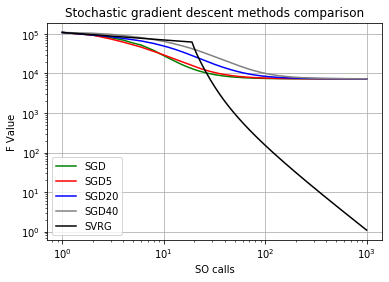

In [5]:
for i in tqdm(range(num_of_simulations),total=num_of_simulations):
    SGD = SGD5 = SGD20 = SGD40 = SVRG = None
    matrix_with_noise, matrix, alpha, beta, R, L = creating_matrix(max_range, min_range, rows, columns,
                                                               x_noise_mean, x_noise_sd, b_noise_mean, b_noise_sd)
    SGD = Stochastic_gradient_descent(iterations, rows, columns, matrix, matrix_with_noise, alpha, dim, beta, batch_size=1)
    SGD5 = Stochastic_gradient_descent(iterations, rows, columns, matrix, matrix_with_noise, alpha, dim, beta, batch_size=5)
    SGD20 = Stochastic_gradient_descent(iterations, rows, columns, matrix, matrix_with_noise, alpha, dim, beta, batch_size=20)
    SGD40 = Stochastic_gradient_descent(iterations, rows, columns, matrix, matrix_with_noise, alpha, dim, beta, batch_size=40)
    SVRG, SVRG_pass = SVRG_function(iterations, rows, columns, matrix, matrix_with_noise, alpha, dim, beta)

plot(SGD, SGD5, SGD20, SGD40, SVRG, SVRG_pass,  iterations, num_of_simulations)